<a href="https://colab.research.google.com/github/manumeehl/trajectories/blob/main/trajectories.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt install tesseract-ocr
!pip install opencv-python-headless pytesseract pytube

In [89]:
from google.colab.patches import cv2_imshow as show
from pytube import YouTube
import pandas as pd
import pytesseract
import cv2
import re

In [19]:
def get_video(url, path):
  vid = YouTube(url)
  print(f"Downloading Video '{vid.streams[0].title}'")
  vid.streams.filter(progressive=True, file_extension='mp4').order_by('resolution').desc().first().download(output_path=path, filename='launch.mp4')
  print('Download complete')

In [ ]:
def custom_crop(frame):
  height, width, _ = frame.shape
  return frame[height-140:height,0:1920]

In [76]:
def clock_to_secs(clockstring):
  ''' Convert a mission clock string to an integer second value '''
  tense = -1 if clockstring[:2] == 't-' else 1
  # Remove the T+- sign
  clockstring = clockstring [2:]
  # Get the seconds
  units = clockstring.split(':')
  hours = int(units[0])
  minutes = int(units[1])
  seconds = int(units[2])

  return hours * 3600 + minutes * 60 + seconds

In [108]:
def get_props(string):
  ''' Extract mission clock, altitude and velocity from a given string '''
  string = string.lower()

  # Apply a blacklist
  blacklist = ['stage 1', 'stage 2', 'falcon 9']
  for w in blacklist:
    string = string.replace(w, '')

  # Find all numbers and floats in the string
  numbers = re.findall(r'\d+(?:\.\d+)?', string)

  # Find the mission clock (T+00:00:00)
  mission_clock = re.findall(r't[+-]\d{2}:\d{2}:\d{2}', string)

  if mission_clock:
    mission_clock = mission_clock[0]

    # Remove numbers which also occur in the mission clock
    mission_clock_numbers = re.findall(r'\d+(?:\.\d+)?', ' '.join(mission_clock))
    for num in mission_clock_numbers:
      if num in numbers:
        numbers.remove(num)

    # Calculate the elapsed amount of seconds
    elapsed = clock_to_secs(mission_clock)
  else:
    mission_clock = ''
    elapsed = 0

  # Remove duplicates from the numbers list
  numbers = list(set([float(x) for x in numbers]))

  altitude, velocity = 0, 0
  if numbers:
    altitude = min(numbers)
    velocity = max(numbers)

  # Return the sorted numbers and mission clock
  return {
      'Clock': mission_clock,
      'Elapsed': elapsed,
      'Velocity': velocity,
      'Altitude': altitude
  }

In [92]:
def extract_data(frame):
  crop = custom_crop(frame)
  gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
  inverted = cv2.bitwise_not(gray)

  text = pytesseract.image_to_string(inverted)
  return get_props(text)

In [101]:
def await_liftoff():
  ''' Identify the frame at which liftoff occurs '''
  framepos = 0
  interval = 300
  clock = ''
  # Await first mission clock appearance
  while vid.isOpened():
    vid.set(cv2.CAP_PROP_POS_FRAMES, int(framepos))
    framepos += interval

    ret, frame = vid.read()
    data = extract_data(frame)

    if data['Clock']:
      clock = data['Clock']
      break

  # Now wait until the next full second
  interval = 1
  while vid.isOpened():
    vid.set(cv2.CAP_PROP_POS_FRAMES, int(framepos))
    framepos += interval

    ret, frame = vid.read()
    data = extract_data(frame)

    if data['Clock'] and data['Clock'] != clock:
      framepos += data['Elapsed'] * fps
      return framepos


In [109]:
def process_launch(vid, liftoff_frame):
  interval = 10

  framepos = liftoff_frame

  monitor = pd.DataFrame(columns = ['Clock', 'Elapsed', 'Altitude', 'Velocity'])

  while vid.isOpened():
    vid.set(cv2.CAP_PROP_POS_FRAMES, int(framepos))
    framepos += interval

    ret, frame = vid.read()
    data = extract_data(frame)

    # Check if we already have a valid dataset for this second
    if data['Elapsed'] not in monitor['Elapsed'] and data['Clock']:
      monitor.loc[len(monitor)] = data

    if framepos > liftoff_frame + 300:
      break

  print(monitor)

In [21]:
url = 'https://www.youtube.com/watch?v=agYuEAkEljw'
get_video(url, 'launches')

Download complete


In [107]:
vidpath = 'launches/launch.mp4'
vid = cv2.VideoCapture(vidpath)
fps = vid.get(cv2.CAP_PROP_FPS)

print('Awaiting liftoff')
liftoff_frame = await_liftoff()
print('Liftoff registered, now monitoring launch')

#vid.set(cv2.CAP_PROP_POS_FRAMES, int(liftoff_frame))
#ret, frame = vid.read()
#show(frame)

process_launch(vid, liftoff_frame)

Awaiting liftoff
Liftoff registered, now monitoring launch
         Clock  Elapsed Altitude Velocity
0   t+00:00:00        0       00       00
1   t+00:00:01        1      0.1       01
2   t+00:00:02        2      0.1        6
3   t+00:00:03        3       00       03
4   t+00:00:04        4       00       04
5   t+00:00:05        5       00        7
6   t+00:00:06        6       00       40
7   t+00:00:07        7       00        8
8   t+00:00:08        8       00        9
9   t+00:00:09        9       00       09
10  t+00:00:10       10       00       10


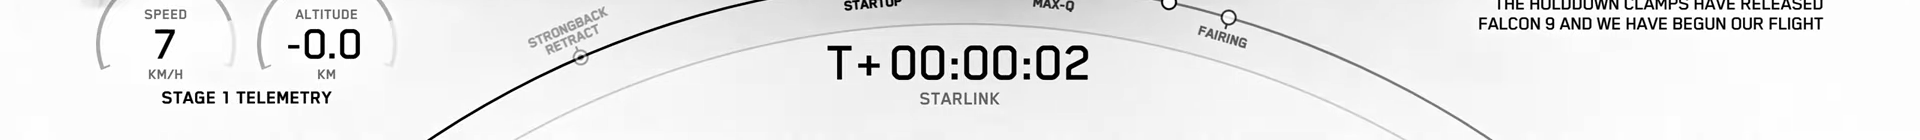

{'clock': 't+00:00:02', 'seconds': 2, 'velocity': '7', 'altitude': '0.0'}


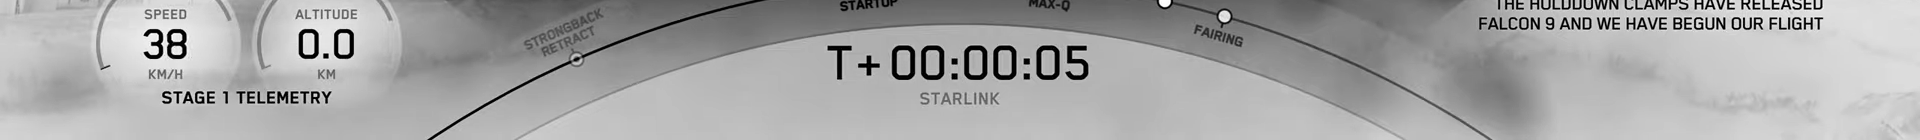

{'clock': 't+00:00:05', 'seconds': 5, 'velocity': '38', 'altitude': '0.0'}


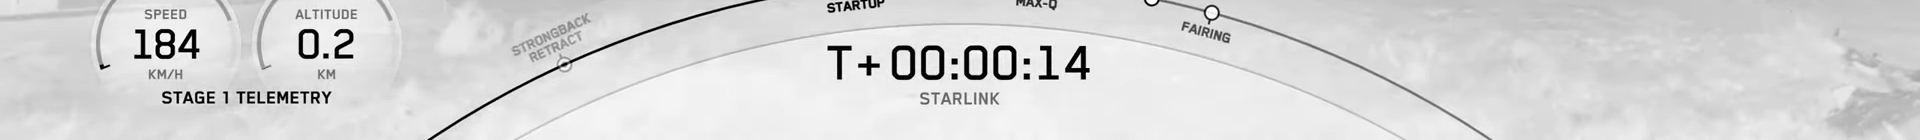

{'clock': 't+00:00:14', 'seconds': 14, 'velocity': '184', 'altitude': '0.2'}


In [88]:
for i in range(3):
  frame = cv2.imread(f'frames/frame_{i+1}.png')
  data = extract_data(frame)

  print(data)